This notebook is used to train the model saved as "workingdistro0_1", specifically designed for the RoboCup challenge. Since the Robcup challenge always have hazmat labels rotated in a certain way, this dataset does not have distortation and only has a small amount of random rotation. In addition, when detecting hazmat labels, the Remotely Controlled Vehicle will always be at a range of certain distances, thus, I chose to have lower variability in the size of the hazmat labels. Every batch will have one of each of 63 hazmat labels, along with 1 "null" label.

In [15]:
# Import libraries
from random import random
import numpy as np
import scipy.misc
import cv2
from math import floor, exp, pi, cos, sin
from skimage.color import rgba2rgb
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import img_as_ubyte
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
import keras
from os import listdir
from skimage import img_as_ubyte, img_as_float
from scipy.ndimage import rotate

In [16]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [17]:
# Get a random batch of background images generated by GenerateBackgrounds, of shape (64, 150, 150, 3)
bgs_path = listdir("bgs")
num_bg = len(bgs_path)
def get_bg():
    random_index = floor(num_bg*random())
    path = "bgs/{}".format(bgs_path[random_index])
    return img_as_float(np.load(path))

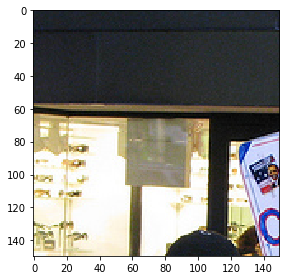

In [18]:
# An example of a background image
batch_background = get_bg
imshow(get_bg()[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


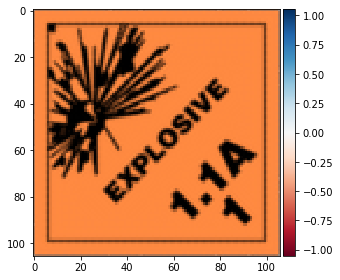

In [19]:
# Store a list of hazmat labels in memory
pics = np.load("pics_rotated.npy")

# An example of a hazmat labels in variable pics
imshow(pics[0])

In [21]:
# Rotate images randomly
def rand_rotate_batch(imgs): 
    return rotate(imgs, (-10 + random() * 20) % 360, reshape=True, mode='constant', cval=0., axes=(1,2))

In [20]:
# Add random noise
# Serves as regularization
def add_noise_batch(img, scale):
    new_img = np.random.normal(img, scale)
    new_img = np.clip(new_img, 0, 1)
    return new_img

In [22]:
# Random brightness and color shift
def hsv_aug_rgb_batch(img_batch):
    return np.clip(img_batch * (0.8 + np.random.random(size=(64,1,1,1)) * 0.4) 
                   + np.random.normal(0, 0.1, (64,1,1,3)), 0, 1) 

In [23]:
# The code below generates a random shadow a batch of images
# Generates random points, and uses an inverse matrix to calculate the corresponding 5th degree polynomial, which will serve as the shadow

# Sigmoid function with a varied rate
def sigmoid(x, rate):
    return 1/(1+np.exp(-rate*x))

# Used to generate a random 5th degree polynomial as a shadow
# Create Mapping A_inv from a set of points to a 5th degree polynomial
A = np.array([4,3,2,1,0])
B = np.array([0,38,75,113,150]).reshape((5,1))
C = np.zeros((5, 1))
P = C + A
A = np.power(B,P)
A_inv = np.linalg.inv(A)

# Used later to apply shadow
I = np.linspace(0, 149, 150, dtype=np.float64).reshape(1,150,1,1)
J = np.linspace(0, 149, 150, dtype=np.float64).reshape(1,1,150,1)

def apply_shadow_batch(img):
    
    shadow = 0.5*random()  # How dark the shadow is
    rate = 0.1 + 0.3*random()  # How sharp the shadow is

    # Random points chosen where the shadow passes through
    X = np.random.normal(75, 25, (5,))
    # Create a the polynomial of the shadow based on X
    p = np.poly1d(np.dot(A_inv, X))
    
    # Random direction of shadow
    _ = random()
    if _ < 0.25:
        multiplier = 1 - shadow * sigmoid(p(I) - J, rate)
    elif _ < 0.5:
        multiplier = 1 - shadow * sigmoid(J - p(I), rate)
    elif _ < 0.75:
        multiplier = 1 - shadow * sigmoid(p(J) - I, rate) 
    else:
        multiplier = 1 - shadow * sigmoid(I - p(J), rate)
    return img * multiplier

In [24]:
# Takes a random section of the 150 by 150 picture
def to_128_batch(img):
    rand_x = floor(random()*22)
    rand_y = floor(random()*22)
    return img[:, rand_x:rand_x+128, rand_y:rand_y+128, :]

In [25]:
# Reduces the size of a batch of images and pad with 0s
def reduce_size(img):
    size_down = int(20*random())
    before = int(size_down/2)
    new_size = 150 - size_down
    new_img = np.zeros((64, new_size, new_size, 4))
    for i in range(64):
        new_img[i]=resize(img[i], (new_size, new_size))
    blank = np.zeros((64, 150, 150, 4))
    blank[:, before: before + new_size, before : before + new_size, :] = new_img
    return blank

In [26]:
# RGBA (Red Green Blue Alpha) to RGB for a batch of pictures of size (batch_size, height, width, 4)
def rgba2rgb_batch(imgs):
    alpha = imgs[:,:,:,3:4]
    stripped = imgs[:,:,:,0:3]
    new_imgs = (1 - alpha) + alpha * stripped
    return new_imgs, alpha

In [27]:
# Define Labels for the training set
LABELS = np.linspace(0, 63, 64, dtype = np.uint8)
LABELS[62:64] = 62
LABELS

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 62], dtype=uint8)

In [28]:
# Generate a batch of training images
def gen_im_batch():
    bg = get_bg()
    pics_rotated = rand_rotate_batch(pics)
    pic = reduce_size(pics_rotated)
    pic, alpha = rgba2rgb_batch(pic)
    pic = hsv_aug_rgb_batch(pic)
    combined = (1 - alpha) * bg + pic * alpha
    combined = add_noise_batch(combined, 0.03)
    combined = apply_shadow_batch(combined)
    combined = to_128_batch(combined)
    combined = hsv_aug_rgb_batch(combined)
    return combined

print(gen_im_batch().shape)

(64, 128, 128, 3)


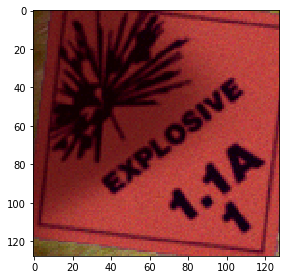

In [32]:
# An example of an image in a batch
b = gen_im_batch()
imshow(b[0])

In [33]:
# Labels for each batch
LABELS_KERAS = keras.utils.to_categorical(LABELS, num_classes=63)

In [34]:
# Modified from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# This DataGenerator class generates batches as the model trains
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, fake_size, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.fake_size = fake_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(fake_size / self.batch_size))

    def __getitem__(self, index):
        # Generate batch
        X, y = self.__data_generation(1)

        return X, y

    def on_epoch_end(self):
        pass
    
    def __data_generation(self, num):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        return gen_im_batch(), LABELS_KERAS

In [ ]:
# Define the model. This is a model inspired by the YOLO Algorithm https://arxiv.org/abs/1506.02640. 
# I use the same 1x1 channels for efficiency, as this application demands a fast run time.
model = Sequential()
model.add(Conv2D(64, kernel_size=7, strides=2, activation='relu', input_shape=(128,128,3)))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(64, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(64, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(128, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(512, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(512, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(1024, kernel_size=3, strides=1, activation='relu'))
model.add(Flatten())
model.add(Dense(63, activation='softmax'))

In [ ]:
# Define optimizer, loss
# The adam optimizer is a very efficient optimizer: https://arxiv.org/abs/1412.6980
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define training parameters
params = {'dim': (128,128),
          'batch_size': 64,
          'n_classes': 63,
          'n_channels': 3
         }

# Datasets
fake_size = 100000

# Generator for training
training_generator = DataGenerator(fake_size, **params)

In [ ]:
# Prevent memory hog by allowing gpu to grow
from tf.compat.v1.keras.backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=False
config.gpu_options.per_process_gpu_memory_fraction = 0.8
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
set_session(sess)

# Print available devices to check if GPU is detected by TensorFlow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
# Train model on dataset
# I ended training this for more epochs, only code for 1 epoch is shown
model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=1
                   )

In [31]:
model.save("workingdistro0_1")